In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
%matplotlib inline

# Questions
1. Find out the empty country
2. For each city, find the most likely city to be searched in the same session
3. cluster sessions into 2 groups

load data

In [2]:
data = pd.read_json("city_search.json")

In [3]:
data.head(3)

,cities,session_id,unix_timestamp,user
0,"[New York NY, Newark NJ]",[X061RFWB06K9V],[1442503708],"[[{'user_id': 2024, 'joining_date': '2015-03-2..."
1,"[New York NY, Jersey City NJ, Philadelphia PA]",[5AZ2X2A9BHH5U],[1441353991],"[[{'user_id': 2853, 'joining_date': '2015-03-2..."
2,[San Antonio TX],[SHTB4IYAX4PX6],[1440843490],"[[{'user_id': 10958, 'joining_date': '2015-03-..."


We need to reformat the data to give a better outlook

In [4]:
data['session_id'] = data['session_id'].apply(lambda l: l[0])
data['session_start_time'] = pd.to_datetime(data['unix_timestamp'].apply(lambda l: l[0]), unit = 's')
data['user_id'] = data['user'].apply(lambda l: l[0][0]['user_id'])
data['country'] = data['user'].apply(lambda l: l[0][0]['country'])
data['joining_date'] = pd.to_datetime(data['user'].apply(lambda l: l[0][0]['joining_date']))
data.drop(['unix_timestamp', 'user'], axis = 1, inplace = True)
data['session_dayofweek'] = data['session_start_time'].apply(lambda d: d.dayofweek)
data['session_daytime'] = data['session_start_time'].apply(lambda d: d.hour)

In [5]:
print("Number of unique users: ", len(data.user_id.unique()))
print("Number of unique countries: ", len(data.country.unique()))
print("Earliest data: {}, latest date: {}".format(data.joining_date.min(), data.joining_date.max()))
data.head()

Number of unique users:  5777
Number of unique countries:  7
Earliest data: 2015-02-28 00:00:00, latest date: 2015-04-03 00:00:00


,cities,session_id,session_start_time,user_id,country,joining_date,session_dayofweek,session_daytime
0,"[New York NY, Newark NJ]",X061RFWB06K9V,2015-09-17 15:28:28,2024,UK,2015-03-22,3,15
1,"[New York NY, Jersey City NJ, Philadelphia PA]",5AZ2X2A9BHH5U,2015-09-04 08:06:31,2853,DE,2015-03-28,4,8
2,[San Antonio TX],SHTB4IYAX4PX6,2015-08-29 10:18:10,10958,UK,2015-03-06,5,10
3,[Edmonton AB],JBRB8MZGTX3M4,2015-03-25 07:21:03,7693,IT,2015-03-12,2,7
4,"[Phoenix AZ, Houston TX]",YJCMPURC2FL9C,2015-05-02 09:31:07,7506,UK,2015-02-28,5,9


In [6]:
#check null values
data.isnull().sum()

cities                0
session_id            0
session_start_time    0
user_id               0
country               0
joining_date          0
session_dayofweek     0
session_daytime       0
dtype: int64

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20022 entries, 0 to 20021
Data columns (total 8 columns):
cities                20022 non-null object
session_id            20022 non-null object
session_start_time    20022 non-null datetime64[ns]
user_id               20022 non-null int64
country               20022 non-null object
joining_date          20022 non-null datetime64[ns]
session_dayofweek     20022 non-null int64
session_daytime       20022 non-null int64
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 1.2+ MB


## Question 1
We can take a look at the time distribution for each country

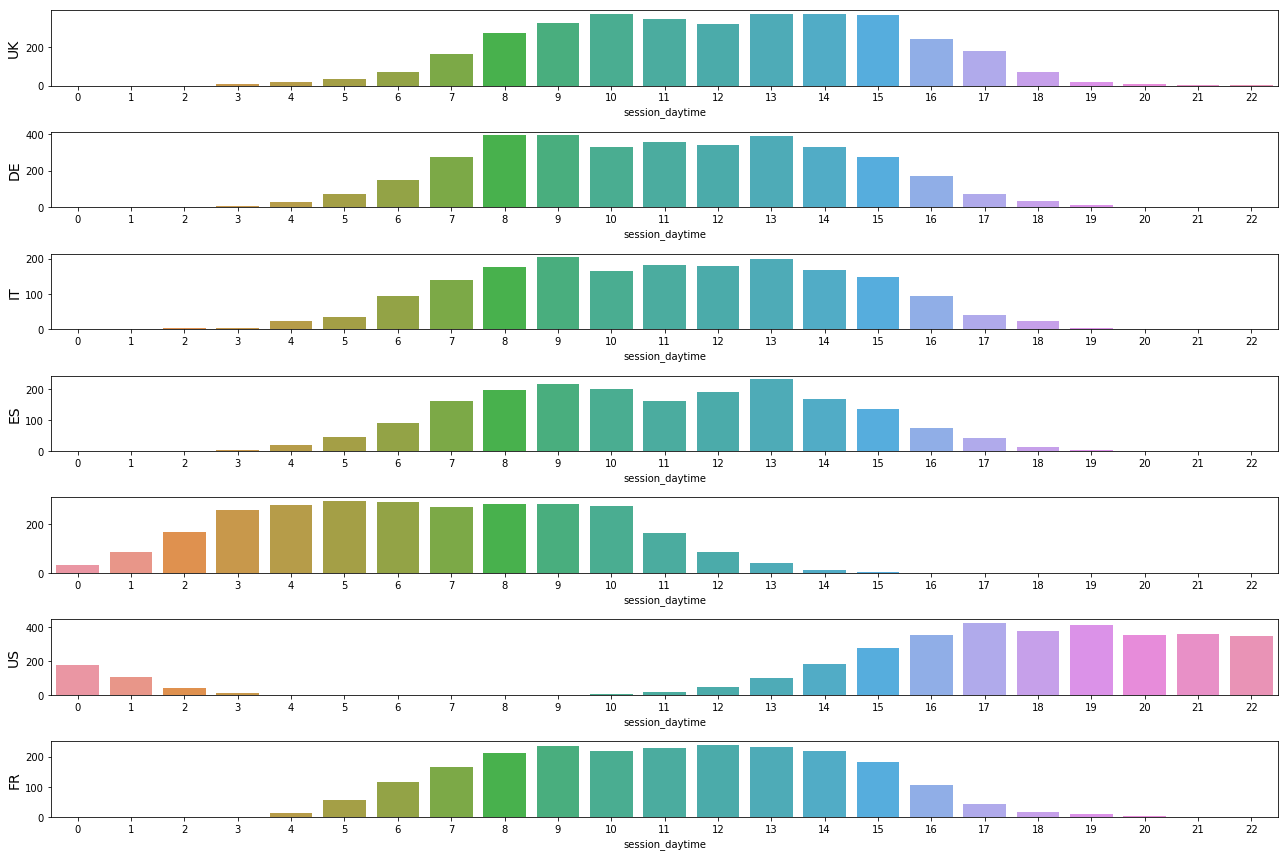

In [12]:
countries = data['country'].unique()
fig, ax = plt.subplots(nrows = len(countries), ncols = 1, figsize = (18,12))

for i,country in enumerate(countries):
    sns.countplot(x = 'session_daytime', data = data[data['country'] == country], ax =ax[i], order = list(range(23)))
    ax[i].set_ylabel(country, fontsize = 14)
plt.tight_layout()

Based on above plot, we can see that the blank country is approximately **10-12** hours ahead of US, and **~5** hours ahead of European countries, so it is very likely to be an Asian country

In [13]:
#replace "" values in data['country'] by CA based on above analysis
data['country'] = data['country'].replace({"": "Asia"})

## Question 2

Step 1. Use a dictionary to map each city with a number <br\>
Step 2. Create a len(unique(city)) * len(unique(city)) matrix, and store counts<br\>
Step 3. Sort count for each city

In [14]:
#step 1
city_index = dict()
num = 0
for val in data.cities:
    city_list = val[0].split(',')
    for city in city_list:
        if city.strip() not in city_index:
            city_index[city.strip()] = num
            num += 1
print("There are {} unique cities".format(len(city_index)))

There are 89 unique cities


In [15]:
#step 2 and 3
city_counts = np.zeros((len(city_index), len(city_index)))
for val in data.cities:
    city_list = [city_index[city.strip()] for city in val[0].split(',')]
    for tup in itertools.permutations(city_list, 2):
        city_counts[tup[0],tup[1]] += 1

city_counts_df = pd.DataFrame(city_counts, columns= city_index.keys(), index = city_index.keys())
city_counts_df.head(3)

,New York NY,Newark NJ,Jersey City NJ,Philadelphia PA,San Antonio TX,Edmonton AB,Phoenix AZ,Houston TX,San Diego CA,Montreal QC,...,Birmingham AL,Nashville TN,Omaha NE,Kansas City MO,Raleigh NC,Greensboro NC,New Orleans LA,Charlotte NC,Lincoln NE,Memphis TN
New York NY,0.0,435.0,549.0,428.0,58.0,39.0,63.0,193.0,60.0,315.0,...,0.0,0.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0
Newark NJ,435.0,0.0,249.0,230.0,0.0,0.0,0.0,0.0,0.0,16.0,...,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0
Jersey City NJ,549.0,249.0,0.0,201.0,0.0,0.0,0.0,0.0,0.0,17.0,...,0.0,0.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0


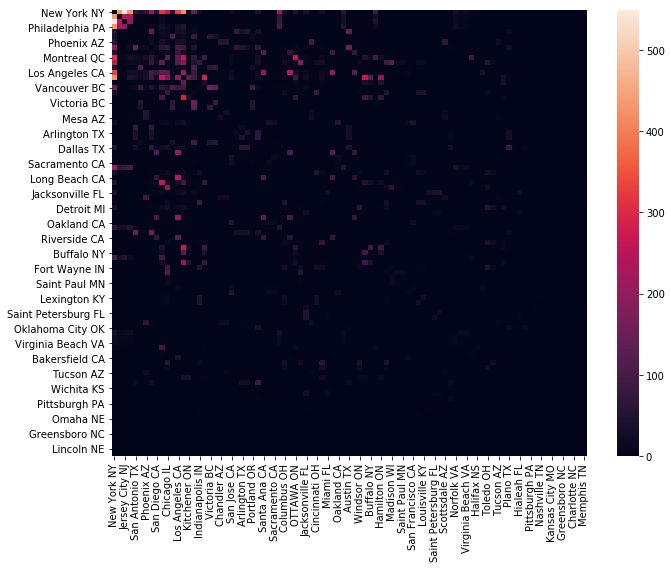

In [17]:
#visualize this count matrix
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(city_counts_df, ax=ax)
plt.tight_layout()

Based on below results, we can see that people are very likely to search for neighboring cities in a same session

In [18]:
#df for every city get its most co-occuring one
city_occur_df = city_counts_df.idxmax().reset_index()
city_occur_df.rename(columns={'index': 'city', 0: 'most similar'}, inplace = True)
city_occur_df

,city,most similar
0,New York NY,Jersey City NJ
1,Newark NJ,New York NY
2,Jersey City NJ,New York NY
3,Philadelphia PA,New York NY
4,San Antonio TX,Houston TX
5,Edmonton AB,Calgary AB
6,Phoenix AZ,Glendale AZ
7,Houston TX,New York NY
8,San Diego CA,Santa Ana CA
9,Montreal QC,New York NY


## Question 3

**Assumptions**
1. If a user searches for **fewer cities** in a session, then this might mean that the user already knows where he/she wants to go, and has a clear plan. And these users are therefore high-intent ones
2. If cities searched by a user in a session is **similar**(find similarity of two cities using cosine similarity of their count vector), then this can indicate that the user has a very clear plan(e.g. the example mentioned in problem description) 

Therefore, I need to create two additional features:
1. num_city_searched
2. city_similarity

In [19]:
#calculate cosine similarity
import scipy.spatial as sp
similarity = 1 - sp.distance.cdist(city_counts_df, city_counts_df, 'cosine')
similarity_df = pd.DataFrame(similarity, columns= city_index.keys(), index = city_index.keys())
similarity_df.head(3)

,New York NY,Newark NJ,Jersey City NJ,Philadelphia PA,San Antonio TX,Edmonton AB,Phoenix AZ,Houston TX,San Diego CA,Montreal QC,...,Birmingham AL,Nashville TN,Omaha NE,Kansas City MO,Raleigh NC,Greensboro NC,New Orleans LA,Charlotte NC,Lincoln NE,Memphis TN
New York NY,1.000000,0.413018,0.306648,0.467476,0.240946,0.223702,0.226022,0.346590,0.223003,0.425465,...,0.052171,0.069599,0.11785,0.083797,0.475620,0.430776,0.018394,0.313661,0.110353,0.01993
Newark NJ,0.413018,1.000000,0.817171,0.812629,0.190719,0.191535,0.311043,0.445001,0.230185,0.490944,...,0.000000,0.000000,0.00000,0.000000,0.611126,0.423373,0.000000,0.387407,0.000000,0.00000
Jersey City NJ,0.306648,0.817171,1.000000,0.867985,0.208551,0.209539,0.339935,0.481567,0.251843,0.526444,...,0.000000,0.000000,0.00000,0.000000,0.547816,0.427990,0.000000,0.364188,0.000000,0.00000


In [20]:
#because this is a similarity, not distance measure, then the larger the value, the more similar the two cities,
#and thus the more likely this is not a dream trip

avg_similarity = list()
for val in data.cities:
    city_list = val[0].split(',')
    if len(city_list) == 1:
        avg_similarity.append(1)
        continue
    score = 0
    for i in range(len(city_list)):
        for j in range(i+1, len(city_list),1):
            score += similarity_df.loc[city_list[i].strip(), city_list[j].strip()]
    avg_similarity.append(score/len(city_list))

In [21]:
data['city_similarity'] = avg_similarity
data['num_city_searched'] = data['cities'].apply(lambda l: len(l[0].split(',')))

C:\Users\sz\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


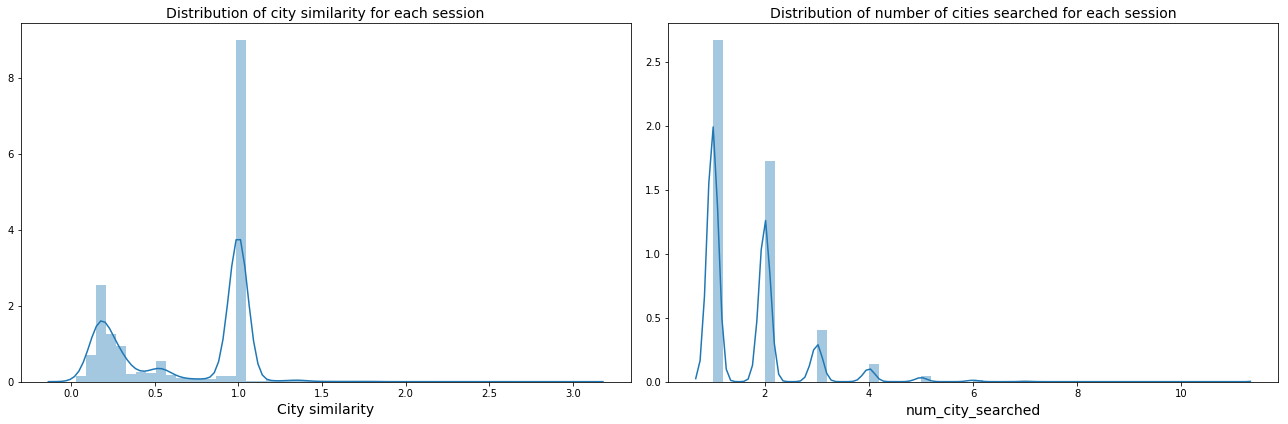

In [28]:
#let's visualize city_similarity and num_city_searched distribution
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,6))
sns.distplot(a=data['city_similarity'], ax =ax[0], bins = 50)
ax[0].set_title("Distribution of city similarity for each session", fontsize = 14)
ax[0].set_xlabel("City similarity", fontsize = 14)

sns.distplot(a = data['num_city_searched'], ax = ax[1])
ax[1].set_title("Distribution of number of cities searched for each session", fontsize = 14)
ax[1].set_xlabel("num_city_searched", fontsize = 14)

plt.tight_layout()

Based on above two distribution plots, we can set a threshold for both features, and for example, if for **city similarity**, if value is less than 0.4, it can indicate low intent. And for **num_city_searched**, we can set threshold to be 3, and those who search >= 3 may have low intent